<a href="https://colab.research.google.com/github/MariaZharova/recsys_internship/blob/main/SASRec_with_userEmb_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install recommenders scrapbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 18.7 MB/s 
     |████████████████████████████████| 355 kB 52.2 MB/s 
     |████████████████████████████████| 4.7 MB 44.4 MB/s 
     |████████████████████████████████| 12.4 MB 45.5 MB/s 
     |████████████████████████████████| 197 kB 39.5 MB/s 
     |████████████████████████████████| 310 kB 40.6 MB/s 
     |████████████████████████████████| 61 kB 7.8 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
     |████████████████████████████████| 11.8 MB 42.0 MB/s 
     |████████████████████████████████| 390 kB 42.9 MB/s 
     |████████████████████████████████| 6.6 MB 41.1 MB/s 
     |████████████████████████████████| 101 kB 8.1 MB/s 
     |████████████████████████████████| 1.6 MB 35.7 MB/s 
     |████████████████████████████████| 71 kB 117 kB/s 
     |████████████████████████████████| 106 kB 44.6 MB/s 
  Created wheel for lightfm: filen

In [2]:
import warnings
warnings.filterwarnings("ignore")

import re
import sys
import os
import scrapbook as sb
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd 

from collections import defaultdict
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
from scipy.sparse import csr_matrix, load_npz

from recommenders.utils.timer import Timer
from recommenders.datasets.split_utils import filter_k_core

# Transformer Based Models
#from recommenders.models.sasrec.model import SASREC

# Sampler for sequential prediction
from recommenders.models.sasrec.sampler import WarpSampler
from recommenders.models.sasrec.util import SASRecDataSet

In [3]:
import random
from tqdm import tqdm

from recommenders.models.sasrec.model import Encoder
from recommenders.models.sasrec.model import LayerNormalization

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class SASREC(tf.keras.Model):
    """SAS Rec model
    Self-Attentive Sequential Recommendation Using Transformer
    :Citation:
        Wang-Cheng Kang, Julian McAuley (2018), Self-Attentive Sequential
        Recommendation. Proceedings of IEEE International Conference on
        Data Mining (ICDM'18)
        Original source code from nnkkmto/SASRec-tf2,
        https://github.com/nnkkmto/SASRec-tf2
    """

    def __init__(self, **kwargs):
        """Model initialization.
        Args:
            item_num (int): Number of items in the dataset.
            seq_max_len (int): Maximum number of items in user history.
            num_blocks (int): Number of Transformer blocks to be used.
            embedding_dim (int): Item embedding dimension.
            attention_dim (int): Transformer attention dimension.
            conv_dims (list): List of the dimensions of the Feedforward layer.
            dropout_rate (float): Dropout rate.
            l2_reg (float): Coefficient of the L2 regularization.
            num_neg_test (int): Number of negative examples used in testing.
        """
        super(SASREC, self).__init__()

        self.item_num = kwargs.get("item_num", None)
        self.seq_max_len = kwargs.get("seq_max_len", 100)
        self.num_blocks = kwargs.get("num_blocks", 2)
        self.embedding_dim = kwargs.get("embedding_dim", 100)
        self.attention_dim = kwargs.get("attention_dim", 100)
        self.attention_num_heads = kwargs.get("attention_num_heads", 1)
        self.conv_dims = kwargs.get("conv_dims", [100, 100])
        self.dropout_rate = kwargs.get("dropout_rate", 0.5)
        self.l2_reg = kwargs.get("l2_reg", 0.0)
        self.num_neg_test = kwargs.get("num_neg_test", 100)

        self.item_embedding_layer = tf.keras.layers.Embedding(
            self.item_num + 1,
            self.embedding_dim,
            name="item_embeddings",
            mask_zero=True,
            embeddings_regularizer=tf.keras.regularizers.L2(self.l2_reg),
        )

        self.positional_embedding_layer = tf.keras.layers.Embedding(
            self.seq_max_len,
            self.embedding_dim,
            name="positional_embeddings",
            mask_zero=False,
            embeddings_regularizer=tf.keras.regularizers.L2(self.l2_reg),
        )
        self.dropout_layer = tf.keras.layers.Dropout(self.dropout_rate)
        self.encoder = Encoder(
            self.num_blocks,
            self.seq_max_len,
            self.embedding_dim,
            self.attention_dim,
            self.attention_num_heads,
            self.conv_dims,
            self.dropout_rate,
        )
        self.mask_layer = tf.keras.layers.Masking(mask_value=0)
        self.layer_normalization = LayerNormalization(
            self.seq_max_len, self.embedding_dim, 1e-08
        )

    def embedding(self, input_seq):
        """Compute the sequence and positional embeddings.
        Args:
            input_seq (tf.Tensor): Input sequence
        Returns:
            tf.Tensor, tf.Tensor:
            - Sequence embeddings.
            - Positional embeddings.
        """

        seq_embeddings = self.item_embedding_layer(input_seq)
        seq_embeddings = seq_embeddings * (self.embedding_dim ** 0.5)

        # FIXME
        positional_seq = tf.expand_dims(tf.range(tf.shape(input_seq)[1]), 0)
        positional_seq = tf.tile(positional_seq, [tf.shape(input_seq)[0], 1])
        positional_embeddings = self.positional_embedding_layer(positional_seq)

        return seq_embeddings, positional_embeddings

    def call(self, x, training):
        """Model forward pass.
        Args:
            x (tf.Tensor): Input tensor.
            training (tf.Tensor): Training tensor.
        Returns:
            tf.Tensor, tf.Tensor, tf.Tensor:
            - Logits of the positive examples.
            - Logits of the negative examples.
            - Mask for nonzero targets
        """

        input_seq = x["input_seq"]
        pos = x["positive"]
        neg = x["negative"]

        mask = tf.expand_dims(tf.cast(tf.not_equal(input_seq, 0), tf.float32), -1)
        seq_embeddings, positional_embeddings = self.embedding(input_seq)

        # add positional embeddings
        seq_embeddings += positional_embeddings

        # dropout
        seq_embeddings = self.dropout_layer(seq_embeddings)

        # masking
        seq_embeddings *= mask

        # --- ATTENTION BLOCKS ---
        seq_attention = seq_embeddings
        seq_attention = self.encoder(seq_attention, training, mask)
        seq_attention = self.layer_normalization(seq_attention)  # (b, s, d)

        # --- PREDICTION LAYER ---
        # user's sequence embedding
        pos = self.mask_layer(pos)
        neg = self.mask_layer(neg)

        pos = tf.reshape(pos, [tf.shape(input_seq)[0] * self.seq_max_len])
        neg = tf.reshape(neg, [tf.shape(input_seq)[0] * self.seq_max_len])
        pos_emb = self.item_embedding_layer(pos)
        neg_emb = self.item_embedding_layer(neg)
        seq_emb = tf.reshape(
            seq_attention,
            [tf.shape(input_seq)[0] * self.seq_max_len, self.embedding_dim],
        )  # (b*s, d)

        pos_logits = tf.reduce_sum(pos_emb * seq_emb, -1)
        neg_logits = tf.reduce_sum(neg_emb * seq_emb, -1)

        pos_logits = tf.expand_dims(pos_logits, axis=-1)  # (bs, 1)
        # pos_prob = tf.keras.layers.Dense(1, activation='sigmoid')(pos_logits)  # (bs, 1)

        neg_logits = tf.expand_dims(neg_logits, axis=-1)  # (bs, 1)
        # neg_prob = tf.keras.layers.Dense(1, activation='sigmoid')(neg_logits)  # (bs, 1)

        # output = tf.concat([pos_logits, neg_logits], axis=0)

        # masking for loss calculation
        istarget = tf.reshape(
            tf.cast(tf.not_equal(pos, 0), dtype=tf.float32),
            [tf.shape(input_seq)[0] * self.seq_max_len],
        )

        return pos_logits, neg_logits, istarget

    def predict(self, inputs):
        """Returns the logits for the test items.
        Args:
            inputs (tf.Tensor): Input tensor.
        Returns:
             tf.Tensor: Output tensor.
        """
        training = False
        input_seq = inputs["input_seq"]
        candidate = inputs["candidate"]

        mask = tf.expand_dims(tf.cast(tf.not_equal(input_seq, 0), tf.float32), -1)
        seq_embeddings, positional_embeddings = self.embedding(input_seq)
        seq_embeddings += positional_embeddings
        # seq_embeddings = self.dropout_layer(seq_embeddings)
        seq_embeddings *= mask
        seq_attention = seq_embeddings
        seq_attention = self.encoder(seq_attention, training, mask)
        seq_attention = self.layer_normalization(seq_attention)  # (b, s, d)
        seq_emb = tf.reshape(
            seq_attention,
            [tf.shape(input_seq)[0] * self.seq_max_len, self.embedding_dim],
        )  # (b*s, d)
        candidate_emb = self.item_embedding_layer(candidate)  # (b, s, d)
        candidate_emb = tf.transpose(candidate_emb, perm=[0, 2, 1])  # (b, d, s)

        test_logits = tf.matmul(seq_emb, candidate_emb)
        # (200, 100) * (1, 101, 100)'

        test_logits = tf.reshape(
            test_logits,
            [tf.shape(input_seq)[0], self.seq_max_len, 1 + self.num_neg_test],
        )  # (1, 200, 101)
        test_logits = test_logits[:, -1, :]  # (1, 101)
        return test_logits

    def loss_function(self, pos_logits, neg_logits, istarget):
        """Losses are calculated separately for the positive and negative
        items based on the corresponding logits. A mask is included to
        take care of the zero items (added for padding).
        Args:
            pos_logits (tf.Tensor): Logits of the positive examples.
            neg_logits (tf.Tensor): Logits of the negative examples.
            istarget (tf.Tensor): Mask for nonzero targets.
        Returns:
            float: Loss.
        """

        pos_logits = pos_logits[:, 0]
        neg_logits = neg_logits[:, 0]

        # ignore padding items (0)
        # istarget = tf.reshape(
        #     tf.cast(tf.not_equal(self.pos, 0), dtype=tf.float32),
        #     [tf.shape(self.input_seq)[0] * self.seq_max_len],
        # )
        # for logits
        loss = tf.reduce_sum(
            -tf.math.log(tf.math.sigmoid(pos_logits) + 1e-24) * istarget
            - tf.math.log(1 - tf.math.sigmoid(neg_logits) + 1e-24) * istarget
        ) / tf.reduce_sum(istarget)

        # for probabilities
        # loss = tf.reduce_sum(
        #         - tf.math.log(pos_logits + 1e-24) * istarget -
        #         tf.math.log(1 - neg_logits + 1e-24) * istarget
        # ) / tf.reduce_sum(istarget)
        reg_loss = tf.compat.v1.losses.get_regularization_loss()
        # reg_losses = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
        # loss += sum(reg_losses)
        loss += reg_loss

        return loss

    def create_combined_dataset(self, u, seq, pos, neg):
        """
        function to create model inputs from sampled batch data.
        This function is used only during training.
        """
        inputs = {}
        seq = tf.keras.preprocessing.sequence.pad_sequences(
            seq, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )
        pos = tf.keras.preprocessing.sequence.pad_sequences(
            pos, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )
        neg = tf.keras.preprocessing.sequence.pad_sequences(
            neg, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )

        inputs["users"] = np.expand_dims(np.array(u), axis=-1)
        inputs["input_seq"] = seq
        inputs["positive"] = pos
        inputs["negative"] = neg

        target = np.concatenate(
            [
                np.repeat(1, seq.shape[0] * seq.shape[1]),
                np.repeat(0, seq.shape[0] * seq.shape[1]),
            ],
            axis=0,
        )
        target = np.expand_dims(target, axis=-1)
        return inputs, target

    def get_user_embedding(self, inputs):
        """Returns embedding for ine user (by input seq).

        Args:
            inputs (tf.Tensor): Input tensor.

        Returns:
             np.ndarray
        """
        training = False
        input_seq = inputs["input_seq"]
        candidate = inputs["candidate"]

        mask = tf.expand_dims(tf.cast(tf.not_equal(input_seq, 0), tf.float32), -1)
        seq_embeddings, positional_embeddings = self.embedding(input_seq)
        seq_embeddings += positional_embeddings
        # seq_embeddings = self.dropout_layer(seq_embeddings)
        seq_embeddings *= mask
        seq_attention = seq_embeddings
        seq_attention = self.encoder(seq_attention, training, mask)
        seq_attention = self.layer_normalization(seq_attention)  # (b, s, d)
        seq_emb = tf.reshape(
            seq_attention,
            [tf.shape(input_seq)[0] * self.seq_max_len, self.embedding_dim],
        )  # (b*s, d)

        return seq_emb.numpy()[np.where(mask.numpy().reshape(-1, 1) == 1)[0]].mean(axis=0)

    """def train(self, dataset, sampler, **kwargs):
        
        #High level function for model training as well as
        #evaluation on the validation and test dataset
        
        num_epochs = kwargs.get("num_epochs", 10)
        batch_size = kwargs.get("batch_size", 128)
        lr = kwargs.get("learning_rate", 0.001)
        val_epoch = kwargs.get("val_epoch", 5)

        num_steps = int(len(dataset.user_train) / batch_size)

        optimizer = tf.keras.optimizers.Adam(
            learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-7
        )

        loss_function = self.loss_function

        train_loss = tf.keras.metrics.Mean(name="train_loss")

        train_step_signature = [
            {
                "users": tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
                "input_seq": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
                "positive": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
                "negative": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
            },
            tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
        ]

        @tf.function(input_signature=train_step_signature)
        def train_step(inp, tar):
            with tf.GradientTape() as tape:
                pos_logits, neg_logits, loss_mask = self(inp, training=True)
                loss = loss_function(pos_logits, neg_logits, loss_mask)

            gradients = tape.gradient(loss, self.trainable_variables)
            #gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients]
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            train_loss(loss)
            return loss

        T = 0.0
        t0 = Timer()
        t0.start()

        for epoch in range(1, num_epochs + 1):

            WATCH_LOSS = 0
            counter = 0
            step_loss = []
            train_loss.reset_states()
            for step in tqdm(
                range(num_steps), total=num_steps, ncols=70, leave=False, unit="b"
            ):

                u, seq, pos, neg = sampler.next_batch()

                inputs, target = self.create_combined_dataset(u, seq, pos, neg)

                loss = train_step(inputs, target)
                step_loss.append(loss)
                WATCH_LOSS += loss
                counter += 1
            
            print(f"\nIn {epoch} epoch the LOSS is {WATCH_LOSS/counter}")
            # self.save

            if epoch % val_epoch == 0:
                t0.stop()
                t1 = t0.interval
                T += t1
                print("Evaluating...")
                t_test = self.evaluate(dataset)
                t_valid = self.evaluate_valid(dataset)
                print(
                    f"\nepoch: {epoch}, time: {T}, valid (NDCG@10: {t_valid[0]}, HR@10: {t_valid[1]})"
                )
                print(
                    f"epoch: {epoch}, time: {T},  test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})"
                )
                t0.start()

            if epoch == num_epochs:
                t0.stop()
                t1 = t0.interval
                T += t1
                print("Getting user's embeddings...")
                user_embeddings = self.get_all_user_embeddings(dataset)
                print("Nice:)")
                t0.start()

        t_test = self.evaluate(dataset)
        print(f"\nepoch: {epoch}, test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})")

        return t_test, user_embeddings

    def get_all_user_embeddings(self, dataset):
        
        #dhgkhdkjghdhfg
        
        usernum = dataset.usernum
        itemnum = dataset.itemnum
        train = dataset.user_train  # removing deepcopy
        valid = dataset.user_valid
        test = dataset.user_test

        # =========== усечённый
        if usernum > 5000:
            users = random.sample(range(1, usernum + 1), 5000)
        else:
            users = range(1, usernum + 1)
        #users = range(1, usernum + 1)   ====== вариант для всех пользаков
        

        all_users_embeddings = []

        for u in tqdm(users, ncols=70, leave=False, unit="b"):

            if len(train[u]) < 1 or len(test[u]) < 1:
                continue

            seq = np.zeros([self.seq_max_len], dtype=np.int32)
            idx = self.seq_max_len - 1
            seq[idx] = valid[u][0]
            idx -= 1
            for i in reversed(train[u]):
                seq[idx] = i
                idx -= 1
                if idx == -1:
                    break
            rated = set(train[u])
            rated.add(0)
            item_idx = [test[u][0]]
            for _ in range(self.num_neg_test):
                t = np.random.randint(1, itemnum + 1)
                while t in rated:
                    t = np.random.randint(1, itemnum + 1)
                item_idx.append(t)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            all_users_embeddings.append(self.get_user_embedding(inputs))

        return all_users_embeddings"""

    def evaluate(self, dataset):
        """
        Evaluation on the test users (users with at least 3 items)
        """
        usernum = dataset.usernum
        itemnum = dataset.itemnum
        train = dataset.user_train  # removing deepcopy
        valid = dataset.user_valid
        test = dataset.user_test

        NDCG = 0.0
        HT = 0.0
        valid_user = 0.0

        if usernum > 100:
            users = random.sample(range(1, usernum + 1), 100)
        else:
            users = range(1, usernum + 1)

        for u in tqdm(users, ncols=70, leave=False, unit="b"):

            if len(train[u]) < 1 or len(test[u]) < 1:
                continue

            seq = np.zeros([self.seq_max_len], dtype=np.int32)
            idx = self.seq_max_len - 1
            seq[idx] = valid[u][0]
            idx -= 1
            for i in reversed(train[u]):
                seq[idx] = i
                idx -= 1
                if idx == -1:
                    break
            rated = set(train[u])
            rated.add(0)
            item_idx = [test[u][0]]
            for _ in range(self.num_neg_test):
                t = np.random.randint(1, itemnum + 1)
                while t in rated:
                    t = np.random.randint(1, itemnum + 1)
                item_idx.append(t)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            # inverse to get descending sort
            predictions = -1.0 * self.predict(inputs)
            predictions = np.array(predictions)
            predictions = predictions[0]

            rank = predictions.argsort().argsort()[0]

            valid_user += 1

            if rank < 10:
                NDCG += 1 / np.log2(rank + 2)
                HT += 1

        return NDCG / valid_user, HT / valid_user

    def evaluate_valid(self, dataset):
        """
        Evaluation on the validation users
        """
        usernum = dataset.usernum
        itemnum = dataset.itemnum
        train = dataset.user_train  # removing deepcopy
        valid = dataset.user_valid

        NDCG = 0.0
        valid_user = 0.0
        HT = 0.0
        if usernum > 100:
            users = random.sample(range(1, usernum + 1), 100)
        else:
            users = range(1, usernum + 1)

        for u in tqdm(users, ncols=70, leave=False, unit="b"):
            if len(train[u]) < 1 or len(valid[u]) < 1:
                continue

            seq = np.zeros([self.seq_max_len], dtype=np.int32)
            idx = self.seq_max_len - 1
            for i in reversed(train[u]):
                seq[idx] = i
                idx -= 1
                if idx == -1:
                    break

            rated = set(train[u])
            rated.add(0)
            item_idx = [valid[u][0]]
            for _ in range(self.num_neg_test):
                t = np.random.randint(1, itemnum + 1)
                while t in rated:
                    t = np.random.randint(1, itemnum + 1)
                item_idx.append(t)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            # predictions = -model.predict(sess, [u], [seq], item_idx)
            predictions = -1.0 * self.predict(inputs)
            predictions = np.array(predictions)
            predictions = predictions[0]

            rank = predictions.argsort().argsort()[0]

            valid_user += 1

            if rank < 10:
                NDCG += 1 / np.log2(rank + 2)
                HT += 1

        return NDCG / valid_user, HT / valid_user

# Выделим пользователей для обучения и для построения разложений эмбедов

Можно в дальнейшем не запускать эту часть кода

In [22]:
out_txt = pd.read_csv('./drive/MyDrive/out_1808.txt', sep='\t', header=None)
out_txt.columns = ['user_id', 'offer_id']
out_txt

,user_id,offer_id
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
8663642,431982,192929
8663643,431982,220742
8663644,431982,277534
8663645,431982,156059


In [27]:
# выделяем ползователей для модели и для разложений
#random.seed(10)
#random_users = random.sample(range(1, out_txt['user_id'].max() + 1), 5000)
model_out = out_txt[out_txt['user_id'] < 420000]
pcatsne_out = out_txt[out_txt['user_id'] >= 420000]
print(model_out.shape, pcatsne_out.shape)
print(model_out['user_id'].unique().shape, pcatsne_out['user_id'].unique().shape)

(8558387, 2) (105260, 2)
(419999,) (11983,)


In [28]:
# отфильтруем так, чтобы в файле для разложений были только объявки из тех, что покажем модели
print('Bef:', pcatsne_out.shape, pcatsne_out['user_id'].unique().shape, pcatsne_out['offer_id'].unique().shape)
model_offers = model_out['offer_id'].unique()
pcatsne_out = pcatsne_out[pcatsne_out['offer_id'].isin(model_offers)]
print('Aft:', pcatsne_out.shape, pcatsne_out['user_id'].unique().shape, pcatsne_out['offer_id'].unique().shape)

Bef: (105260, 2) (11983,) (81061,)
Aft: (105260, 2) (11983,) (81061,)


In [15]:
# сохраним файлы с данными
model_out[['user_id', 'offer_id']].to_csv('./drive/MyDrive/out_model.txt', sep='\t', header=False, index=False)
pcatsne_out[['user_id', 'offer_id']].to_csv('./drive/MyDrive/out_pcatsne.txt', sep='\t', header=False, index=False)

# Переходим к модели

In [29]:
# create special data format for SAS
data_model = SASRecDataSet(filename='./drive/MyDrive/out_1808.txt', col_sep='\t')
# split into train, test and validation
data_model.split()

data_pcatsne = SASRecDataSet(filename='./drive/MyDrive/out_pcatsne.txt', col_sep='\t')
data_pcatsne.split()

KeyboardInterrupt: ignored

In [19]:
print(data_model.usernum)
print(data_model.itemnum)
#print(data_pcatsne.usernum)
#print(data_pcatsne.itemnum)

431982
388607


In [18]:
# model variables
num_epochs = 11
batch_size = 200   #                                                         !!!
RANDOM_SEED = 100  # Set None for non-deterministic result
lr = 0.001             # learning rate                                       !!!
maxlen = 50            # maximum sequence length for each user
num_blocks = 2         # number of transformer blocks
hidden_units = 100     # number of units in the attention calculation.       !!!
num_heads = 1          # number of attention heads
dropout_rate = 0.1     # dropout rate
l2_emb = 0.0           # L2 regularization coefficient                       !!!
num_neg_test = data_model.itemnum  # number of negative examples per positive example


In [19]:
# sample negative examples
sampler = WarpSampler(data_model.user_train, data_model.usernum, data_model.itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=3)

In [20]:
model = SASREC(item_num=data_model.itemnum,
               seq_max_len=maxlen,
               num_blocks=num_blocks,
               embedding_dim=hidden_units,
               attention_dim=hidden_units,
               attention_num_heads=num_heads,
               dropout_rate=dropout_rate,
               conv_dims = [hidden_units, hidden_units],         ### !!!
               l2_reg=l2_emb,
               num_neg_test=num_neg_test)

In [ ]:
def get_all_user_embeddings(model, dataset):
    """
        Returns embeddings for fixed users
    """
    usernum = dataset.usernum
    itemnum = dataset.itemnum
    train = dataset.user_train  # removing deepcopy
    valid = dataset.user_valid
    test = dataset.user_test

    # =========== усечённый
    if usernum > 5000:
        users = random.sample(range(1, usernum + 1), 5000)
    else:
        users = range(1, usernum + 1)
    #users = range(1, usernum + 1)   ====== вариант для всех пользаков
    

    all_users_embeddings = []

    for u in tqdm(users, ncols=70, leave=False, unit="b"):

        if len(train[u]) < 1 or len(test[u]) < 1:
            continue

        seq = np.zeros([model.seq_max_len], dtype=np.int32)
        idx = model.seq_max_len - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1:
                break
        rated = set(train[u])
        rated.add(0)
        item_idx = [test[u][0]]
        for _ in range(model.num_neg_test):
            t = np.random.randint(1, itemnum + 1)
            while t in rated:
                t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        inputs = {}
        inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
        inputs["input_seq"] = np.array([seq])
        inputs["candidate"] = np.array([item_idx])

        all_users_embeddings.append(model.get_user_embedding(inputs))

    return all_users_embeddings

In [21]:
dataset = data_model
val_epoch = 11

num_steps = int(len(data_model.user_train) / batch_size)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-7
)

loss_function = model.loss_function

train_loss = tf.keras.metrics.Mean(name="train_loss")

train_step_signature = [
    {
        "users": tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
        "input_seq": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
        "positive": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
        "negative": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
    },
    tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    with tf.GradientTape() as tape:
        pos_logits, neg_logits, loss_mask = model(inp, training=True)
        loss = loss_function(pos_logits, neg_logits, loss_mask)

    gradients = tape.gradient(loss, model.trainable_variables)
    #gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    return loss

T = 0.0
t0 = Timer()
t0.start()

for epoch in range(1, num_epochs + 1):

    WATCH_LOSS = 0
    counter = 0
    step_loss = []
    train_loss.reset_states()
    for step in tqdm(
        range(num_steps), total=num_steps, ncols=70, leave=False, unit="b"
    ):

        u, seq, pos, neg = sampler.next_batch()

        inputs, target = model.create_combined_dataset(u, seq, pos, neg)

        loss = train_step(inputs, target)
        step_loss.append(loss)
        WATCH_LOSS += loss.numpy()
        counter += 1
    
    print(f"\nIn {epoch} epoch the LOSS is {WATCH_LOSS/counter}")
    if epoch % val_epoch == 0:
        t0.stop()
        t1 = t0.interval
        T += t1
        print("Evaluating...")
        t_test = model.evaluate(data_model)
        t_valid = model.evaluate_valid(data_model)
        print(
            f"\nepoch: {epoch}, time: {T}, valid (NDCG@10: {t_valid[0]}, HR@10: {t_valid[1]})"
        )
        print(
            f"epoch: {epoch}, time: {T},  test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})"
        )
        t0.start()
    # save model
    model.save_weights(f'model_epoch_{epoch}_loss_{round(WATCH_LOSS/counter, 4)}') ### путь

# last evaluation
t_test = model.evaluate(data_model)
print(f"\nepoch: {epoch}, test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})")

# get user's embeddings
t0.stop()
t1 = t0.interval
T += t1
print("Getting user's embeddings...")
user_embeddings = model.get_all_user_embeddings(data_pcatsne)
print("Nice:)")
t0.start()


In 1 epoch the LOSS is 1.004943807100797



In 2 epoch the LOSS is 0.49542203527625484



In 3 epoch the LOSS is 0.2877826127618372



In 4 epoch the LOSS is 0.2070334328579207



In 5 epoch the LOSS is 0.1651629660107737



In 6 epoch the LOSS is 0.13940782519251507



In 7 epoch the LOSS is 0.12217885969813194



In 8 epoch the LOSS is 0.10946209344628123



In 9 epoch the LOSS is 0.0992103637079223



In 10 epoch the LOSS is 0.09198529812653565



In 11 epoch the LOSS is 0.0855971787568318
Evaluating...



epoch: 11, time: 1087.5466169330002, valid (NDCG@10: 0.0620298489032138, HR@10: 0.1)
epoch: 11, time: 1087.5466169330002,  test (NDCG@10: 0.014055596987675978, HR@10: 0.04)
Getting user's embeddings...


Nice:)



epoch: 11, test (NDCG@10: 0.023046663059874142, HR@10: 0.05)


In [22]:
#with Timer() as train_time:
#    t_test, user_embeddings = model.train(dataS, sampler, num_epochs=num_epochs, batch_size=batch_size, lr=lr, val_epoch=2)
user_embeddings

[array([-4.1648474 , -0.22996114, -1.2824564 , -6.1496725 ,  2.496312  ,
         4.0651746 , -0.2962553 , -0.54975104,  3.4981449 ,  3.9005823 ,
        -5.2767143 , -1.2887626 , -1.3209604 ,  1.9980513 ,  0.16680042,
         2.4567997 ,  1.9700929 ,  0.06097014,  3.013162  ,  3.348858  ,
        -1.2330273 ,  0.32254696,  1.0028814 , -0.6621929 ,  7.7168646 ,
         1.2623405 , -0.9103782 , -2.0194027 ,  2.4267714 , -0.7541095 ,
        -0.11679078,  1.9888829 , -2.5589945 ,  2.05647   , -0.15126762,
        -0.6919274 ,  0.7455414 , -1.8996264 ,  1.4471904 , -2.3737538 ,
         2.42393   , -2.027463  ,  0.49750555,  1.2291243 , -0.76113856,
        -0.6865958 , -4.1101117 ,  4.780674  , -2.1293457 ,  0.4927478 ,
         2.2294765 ,  1.1612362 , -2.3060186 , -2.165068  , -3.8044376 ,
         1.5780553 ,  1.9557981 ,  1.0267034 , -0.01965098,  2.6537628 ,
         2.6473527 , -3.1098876 , -4.9101167 ,  3.672497  , -2.640669  ,
         5.725695  , -1.9534978 , -0.5240224 , -0.0

In [23]:
user_embeddings = np.array(user_embeddings)

In [24]:
print(np.min(user_embeddings), np.max(user_embeddings))

-12.364845 11.276773


In [1]:
user_embeddings.shape

NameError: ignored

### Эмбеды пользователей 

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

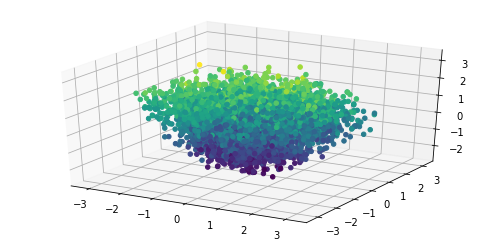

In [28]:
pca = PCA(n_components=3, whiten=True) 
X_pca = pca.fit_transform(user_embeddings)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = X_pca[:,0], X_pca[:,1], X_pca[:,2]
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.799s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 7.585825
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.987579
[t-SNE] KL divergence after 300 iterations: 1.945408


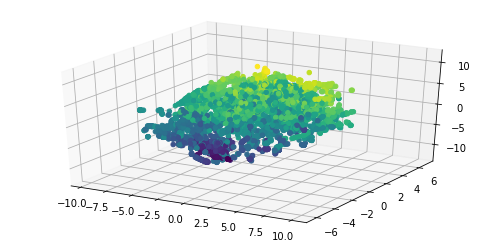

In [29]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(user_embeddings)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = tsne_results[:,0], tsne_results[:,1], tsne_results[:,2]
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()

### Ошибка с DNN

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 25s (16.7 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+

In [ ]:
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

In [ ]:
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.1/642.1 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 14.5 MB/s eta 0:00:00
  Preparing meta

Found existing installation: tensorflow 2.9.1
Uninstalling tensorflow-2.9.1:
  Successfully uninstalled tensorflow-2.9.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
